In [1]:
import numpy as np
import matplotlib.pyplot as plt

from optic.core import parameters
from optic.tx import simpleWDMTx
from optic.amplification import edfaSM, OSA

from scipy.constants import c
from numpy.fft import fft,fftfreq

import logging as logg
logg.getLogger().setLevel(logg.INFO)
logg.basicConfig(format='%(message)s')

In [2]:
from IPython.core.display import HTML
from IPython.core.pylabtools import figsize

HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

In [3]:
figsize(10, 3)

In [11]:
# EDFA parameters
param_edfa = parameters()
param_edfa.type     = "AGC"
param_edfa.value    = 20 #dB
param_edfa.forPump  = {'pump_signal': np.array([100e-3]), 'pump_lambda': np.array([980e-9])}
param_edfa.bckPump  = {'pump_signal': np.array([000e-3]), 'pump_lambda': np.array([980e-9])}
param_edfa.file     = 'C:\\Users\\Adolfo\\Documents\\GitHub\\OptiCommPy\\examples\\giles_MP980.dat'
param_edfa.fileunit = 'nm'
param_edfa.gmtc     = 'Bessel'
param_edfa.tol      = 0.05
param_edfa.tolCtrl  = 0.5

In [5]:
# Transmitter parameters:
paramTx = parameters()
paramTx.M   = 4             # order of the modulation format
paramTx.Rs  = 40e9          # symbol rate [baud]
paramTx.SpS = 256           # samples per symbol
paramTx.Nbits = 2**12       # total number of bits per polarization
paramTx.pulse = 'rrc'       # pulse shaping filter
paramTx.Ntaps = 1024        # number of pulse shaping filter coefficients
paramTx.alphaRRC = 0.01     # RRC rolloff
paramTx.Pch_dBm = -15       # power per WDM channel [dBm]
paramTx.Nch     = 40        # number of WDM channels
paramTx.Fc      = c/1550e-9 # central optical frequency of the WDM spectrum
paramTx.freqSpac = 200e9    # WDM grid spacing
paramTx.Nmodes = 2          # number of signal modes [2 for polarization multiplexed signals]

In [6]:
# generate WDM signal
sigWDM_Tx, symbTx_, paramTx = simpleWDMTx(paramTx)

  0%|          | 0/40 [00:00<?, ?it/s]

channel 0	 fc : 189.5145 THz
  mode #0	 power: -18.01 dBm
  mode #1	 power: -18.01 dBm
channel 0	 power: -15.00 dBm

channel 1	 fc : 189.7145 THz
  mode #0	 power: -18.01 dBm
  mode #1	 power: -18.01 dBm
channel 1	 power: -15.00 dBm

channel 2	 fc : 189.9145 THz
  mode #0	 power: -18.01 dBm
  mode #1	 power: -18.01 dBm
channel 2	 power: -15.00 dBm

channel 3	 fc : 190.1145 THz
  mode #0	 power: -18.01 dBm
  mode #1	 power: -18.01 dBm
channel 3	 power: -15.00 dBm

channel 4	 fc : 190.3145 THz
  mode #0	 power: -18.01 dBm
  mode #1	 power: -18.01 dBm
channel 4	 power: -15.00 dBm

channel 5	 fc : 190.5145 THz
  mode #0	 power: -18.01 dBm
  mode #1	 power: -18.01 dBm
channel 5	 power: -15.00 dBm

channel 6	 fc : 190.7145 THz
  mode #0	 power: -18.01 dBm
  mode #1	 power: -18.01 dBm
channel 6	 power: -15.00 dBm

channel 7	 fc : 190.9145 THz
  mode #0	 power: -18.01 dBm
  mode #1	 power: -18.01 dBm
channel 7	 power: -15.00 dBm

channel 8	 fc : 191.1145 THz
  mode #0	 power: -18.01 dBm
  mode

In [7]:
lenFrqSg,isy = np.shape(sigWDM_Tx)
Fs = paramTx.Rs*paramTx.SpS
#Tw = 1/Fs * (paramTx.Nbits / np.log2(paramTx.M)) * paramTx.SpS
simOpticalBand = (Fs*(c/paramTx.Fc)**2)/c

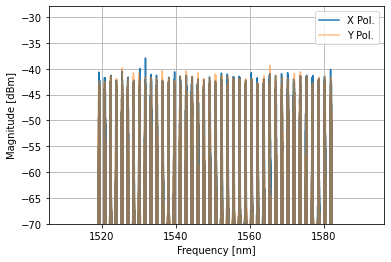

In [8]:
OSA(sigWDM_Tx, Fs, paramTx.Fc)

In [9]:
# information TX
print('Sample rate [THz]: %5.3f' %(1e-12*Fs))
print('Time window [ns]:  %5.3f' %(1e9*lenFrqSg/Fs))
print('Central wavelength [nm]: %6.2f' %(1e9*c/paramTx.Fc))
print('Simulation window  [nm]: %f - [%6.2f nm - %6.2f nm]' 
      %(1e9*simOpticalBand, 1e9*(c/paramTx.Fc-simOpticalBand/2), 1e9*(c/paramTx.Fc+simOpticalBand/2)))
print('Frequency spacing [GHz]: %f' %(1e-9*Fs/lenFrqSg))
print('Number of points: %d' %(lenFrqSg))
print('Number of modes: %d' %(paramTx.Nmodes))
print('Average power - TX [mW] : %.3f mW' %(1000*np.sum(np.mean(sigWDM_Tx * np.conj(sigWDM_Tx), axis = 0).real)))
print('Average power - TX [dBm] : %.3f dBm' %(10*np.log10(np.sum(1000*np.mean(sigWDM_Tx * np.conj(sigWDM_Tx), axis = 0).real))))

Sample rate [THz]: 10.240
Time window [ns]:  51.200
Central wavelength [nm]: 1550.00
Simulation window  [nm]: 82.062104 - [1508.97 nm - 1591.03 nm]
Frequency spacing [GHz]: 0.019531
Number of points: 524288
Number of modes: 2
Average power - TX [mW] : 1.265 mW
Average power - TX [dBm] : 1.021 dBm


In [12]:
#%load_ext line_profiler
#%lprun -f edfaSM edfaSM(sigTxo, Fs, Fc, param_edfa)
# amplification
Eout, PumpF, PumpB = edfaSM(sigWDM_Tx, Fs, paramTx.Fc, param_edfa)


EDF absorption and gain coeficients. Calculating absorption and emission cross-section ...
EDFA SM: loop  1
Convergence: -1.871%.

EDFA SM: control loop  1
Convergence: -3.935 dB
Pump for.: 139.35 mW

EDFA SM: loop  1
Convergence: 27.973%.

EDFA SM: loop  2
Convergence: -0.178%.

EDFA SM: control loop  2
Convergence: -2.398 dB
Pump for.: 163.34 mW

EDFA SM: loop  1
Convergence: 14.616%.

EDFA SM: loop  2
Convergence: -0.037%.

EDFA SM: control loop  3
Convergence: -1.697 dB
Pump for.: 180.31 mW

EDFA SM: loop  1
Convergence: 9.400%.

EDFA SM: loop  2
Convergence: -0.063%.

EDFA SM: control loop  4
Convergence: -1.282 dB
Pump for.: 193.13 mW

EDFA SM: loop  1
Convergence: 6.594%.

EDFA SM: loop  2
Convergence: -0.085%.

EDFA SM: control loop  5
Convergence: -1.000 dB
Pump for.: 203.13 mW

EDFA SM: loop  1
Convergence: 4.853%.

EDFA SM: control loop  6
Convergence: -0.793 dB
Pump for.: 211.05 mW

EDFA SM: loop  1
Convergence: 3.667%.

EDFA SM: control loop  7
Convergence: -0.637 dB
Pump

In [10]:
# information amp
print('Average power - RX amp [mW] : %.3f mW' %(1000*np.sum(np.mean(sigWDM_Tx * np.conj(Eout), axis = 0).real)))
print('Average power - RX amp [dBm] : %.3f dBm' %(10*np.log10(np.sum(1000*np.mean(Eout * np.conj(Eout), axis = 0).real))))

Average power - RX amp [mW] : 10.963 mW
Average power - RX amp [dBm] : 20.599 dBm


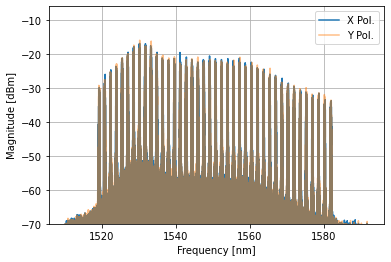

In [11]:
OSA(Eout, Fs, paramTx.Fc)